In [68]:
from fenics import *
from fenics import *
from mshr import *
import numpy as np
import sympy
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
from sympy.printing import ccode
sympy.init_printing()
import sympy.functions.elementary.trigonometric as sym_trig

In [79]:
def gradient(u):
    return sympy.diff(u, x), sympy.diff(u, y)

def laplass(u):
    return sympy.diff(u, x,x) + sympy.diff(u, y,y)

In [81]:
alpha_val = 1
x, y, alpha = sympy.symbols('x[0], x[1], alpha')
u_e = x**2 + y**2

def poisson(u_e):
    f = -sympy.diff(u_e, x, x) - sympy.diff(u_e, y, y) + alpha * u_e

    # Create mesh and define function space
    # Create mesh and define function space
    domain = Circle(Point(0, 0), 1)
    mesh = generate_mesh(domain, 20)
    V = FunctionSpace(mesh, 'P', 2)
    # Define boundary condition

    u_D = Expression(ccode(u_e), degree=2)

    def boundary_D(x, on_boundary):
        if on_boundary:
            if x[1] < 0:
                return True
            else:
                return False
        else:
            return False

    bc = DirichletBC(V, u_D, boundary_D)

    #get normal
    n = FacetNormal(mesh)

    # Define variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    f = Expression(ccode(f), degree = 2, alpha = alpha_val)
    h = Expression('{0} * x[0] / sqrt(x[0]*x[0] + x[1]*x[1]) + {1} * x[1] / sqrt(x[0]*x[0] + x[1]*x[1])'.format(
        ccode(gradient(u_e)[0]), ccode(gradient(u_e)[1])), degree = 2)

    a = dot(grad(u), grad(v))*dx + alpha_val*u*v*dx

    L = f*v*dx + h*v*ds

    # Compute solution
    u = Function(V)
    solve(a == L, u, bc)
    # Plot solution and mesh
    # plot(u)
    # plot(mesh)

    # Save solution to file in VTK format
    vtkfile = File('poisson/solution.pvd')
    vtkfile << u

    # Compute error in L2 norm
    error_L2 = errornorm(u_D, u, 'L2')
    # Compute maximum error at vertices
    vertex_values_u_D = u_D.compute_vertex_values(mesh)
    vertex_values_u = u.compute_vertex_values(mesh)
    error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
    # Print errors
    print('error_L2  =', error_L2)
    print('error_max =', error_max)

    n = mesh.num_vertices()
    d = mesh.geometry().dim()
    mesh_coordinates = mesh.coordinates().reshape((n, d))
    triangles = np.asarray([cell.entities(0) for cell in cells(mesh)])
    triangulation = tri.Triangulation(mesh_coordinates[:, 0], mesh_coordinates[:, 1], triangles)
    plt.figure()
    gs = gridspec.GridSpec(1, 2)

    ax1 = plt.subplot(gs[0])
    zfaces = np.asarray([u(cell.midpoint()) for cell in cells(mesh)])
    ax1.tripcolor(triangulation, facecolors=zfaces, edgecolors='k')
    ax1.set_title('solution')

    ax2 = plt.subplot(gs[1])
    zfaces = np.asarray([u_D(cell.midpoint()) for cell in cells(mesh)])
    ax2.tripcolor(triangulation, facecolors=zfaces, edgecolors='k')
    ax2.set_title('original')


error_L2  = 0.0008246838867997844
error_max = 0.0010008360125


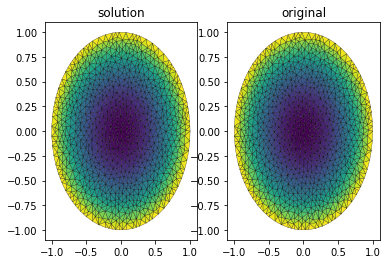

In [71]:
poisson(u_e)

error_L2  = 0.00021176019998233597
error_max = 0.000596292652798


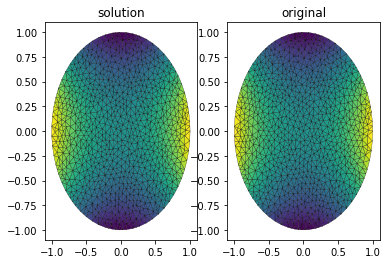

In [72]:
poisson(x**2 - y**2)

error_L2  = 0.19519879723573894
error_max = 0.307838441579


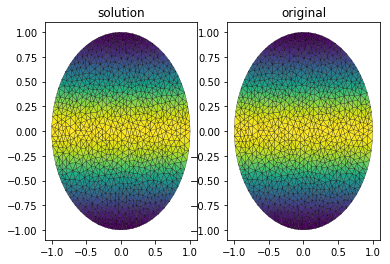

In [73]:
poisson(x**2 * sym_trig.sin(y) + 18*sym_trig.cos(3*y))

# Heat equation

In [134]:
x, y, a, t = sympy.symbols('x[0], x[1], a, t')

u_e = x**2 + y**2 + t

def heat(u_e, num_steps, name):
    x, y, a, t = sympy.symbols('x[0], x[1], a, t')
    T = 2.0
    dt = T / num_steps
    domain = Circle(Point(0, 0), 1)
    mesh = generate_mesh(domain, 20)
    V = FunctionSpace(mesh, 'P', 2)

    u_D = Expression(ccode(u_e), degree=2, t=0)


    def boundary(x, on_boundary):
        if on_boundary:
            if x[1] < 0:
                return True
            else:
                return False
        else:
            return False

    bc = DirichletBC(V, u_D, boundary)

    u_n = interpolate(u_D, V)
    u = TrialFunction(V)
    v = TestFunction(V)
    sympy.diff(u_e, t)
    f = Expression(ccode(sympy.diff(u_e, t) - a * laplass(u_e)), a = 1, degree = 2, t = 0)
    h = Expression(
        '{0} * x[0] / sqrt(x[0]*x[0] + x[1]*x[1]) + {1} * x[1] / sqrt(x[0]*x[0] + x[1]*x[1])'.format(
            ccode(gradient(u_e)[0]), ccode(gradient(u_e)[1])
        ), degree = 2, t = 0
    )

    F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx - dt * v * h * ds
    a, L = lhs(F), rhs(F)
    u = Function(V)
    t=0

    vtkfile = File('heat_poisson/solution_{0}.pvd'.format(name))

    for n in range(num_steps):
        t += dt
        u_D.t = t
        h.t = t
        f.t = t
        solve(a == L, u, bc)
        vtkfile << (u, t)
        u_e = interpolate(u_D, V)
        error = np.abs(u_e.vector().get_local()- u.vector().get_local()).max()
        print(' t = ', t, ',max error = ', error, 'L2 error = ', errornorm(u_e, u, 'L2'))

        u_n.assign(u)

    n = mesh.num_vertices()
    d = mesh.geometry().dim()
    mesh_coordinates = mesh.coordinates().reshape((n, d))
    triangles = np.asarray([cell.entities(0) for cell in cells(mesh)])
    triangulation = tri.Triangulation(mesh_coordinates[:, 0], mesh_coordinates[:, 1], triangles)
    plt.figure()
    gs = gridspec.GridSpec(1, 2)

    ax1 = plt.subplot(gs[0])
    zfaces = np.asarray([u(cell.midpoint()) for cell in cells(mesh)])
    ax1.tripcolor(triangulation, facecolors=zfaces, edgecolors='k')
    ax1.set_title('solution')

    ax2 = plt.subplot(gs[1])
    zfaces = np.asarray([u_e(cell.midpoint()) for cell in cells(mesh)])
    ax2.tripcolor(triangulation, facecolors=zfaces, edgecolors='k')
    ax2.set_title('original')

Calling FFC just-in-time (JIT) compiler, this may take some time.
 t =  0.02 ,max error =  1.57371022261e-05 L2 error =  1.2798157719468676e-06
 t =  0.04 ,max error =  3.16706335513e-05 L2 error =  2.883251349790091e-06
 t =  0.06 ,max error =  4.76681279152e-05 L2 error =  4.784311441261726e-06
 t =  0.08 ,max error =  6.36988439029e-05 L2 error =  6.9475448607262e-06
 t =  0.1 ,max error =  7.97369976464e-05 L2 error =  9.337046135758253e-06
 t =  0.12000000000000001 ,max error =  9.576182452e-05 L2 error =  1.1920916119727135e-05
 t =  0.14 ,max error =  0.000111757161309 L2 error =  1.4672113958551786e-05
 t =  0.16 ,max error =  0.000127710746882 L2 error =  1.7568181259583486e-05
 t =  0.18 ,max error =  0.000143613510031 L2 error =  2.0590647945326355e-05
 t =  0.19999999999999998 ,max error =  0.000159458928494 L2 error =  2.3724395388772682e-05
 t =  0.21999999999999997 ,max error =  0.000175242484042 L2 error =  2.6957071065242242e-05
 t =  0.23999999999999996 ,max error =  

 t =  1.8400000000000012 ,max error =  0.0016269556876 L2 error =  0.00041494944816451913
 t =  1.8600000000000012 ,max error =  0.00164597765528 L2 error =  0.0004205225718693568
 t =  1.8800000000000012 ,max error =  0.00166500818164 L2 error =  0.00042610421470591235
 t =  1.9000000000000012 ,max error =  0.00168404702385 L2 error =  0.0004316941560097935
 t =  1.9200000000000013 ,max error =  0.00170309394598 L2 error =  0.00043729218067403936
 t =  1.9400000000000013 ,max error =  0.00172214871881 L2 error =  0.0004428980790250101
 t =  1.9600000000000013 ,max error =  0.0017412111196 L2 error =  0.00044851164669947984
 t =  1.9800000000000013 ,max error =  0.00176028093196 L2 error =  0.000454132684523447
 t =  2.0000000000000013 ,max error =  0.00177935794563 L2 error =  0.0004597609983932411


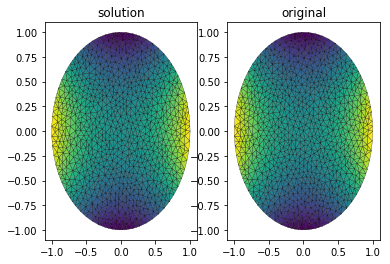

In [141]:
heat((x**2 - y**2) * t, 100, 'test')

 t =  0.02 ,max error =  7.14009707552e-06 L2 error =  5.902871491785587e-07
 t =  0.04 ,max error =  1.43787931108e-05 L2 error =  1.3833570908594762e-06
 t =  0.06 ,max error =  2.18131269861e-05 L2 error =  2.37104032329172e-06
 t =  0.08 ,max error =  2.93537725782e-05 L2 error =  3.5379562588299515e-06
 t =  0.1 ,max error =  3.69860985652e-05 L2 error =  4.867103160794284e-06
 t =  0.12000000000000001 ,max error =  4.46989887061e-05 L2 error =  6.342144578145942e-06
 t =  0.14 ,max error =  5.24832938277e-05 L2 error =  7.947998938066621e-06
 t =  0.16 ,max error =  6.03311662295e-05 L2 error =  9.670943146177956e-06
 t =  0.18 ,max error =  6.84216957418e-05 L2 error =  1.1498570651551792e-05
 t =  0.19999999999999998 ,max error =  7.66835797295e-05 L2 error =  1.3419705338261123e-05
 t =  0.21999999999999997 ,max error =  8.50221619228e-05 L2 error =  1.54243037064864e-05
 t =  0.23999999999999996 ,max error =  9.34281870978e-05 L2 error =  1.7503356558303517e-05
 t =  0.259999

 t =  1.8600000000000012 ,max error =  0.000846011551663 L2 error =  0.00023029109716009505
 t =  1.8800000000000012 ,max error =  0.000855436653646 L2 error =  0.0002329823722383316
 t =  1.9000000000000012 ,max error =  0.000864862145282 L2 error =  0.00023567370963097865
 t =  1.9200000000000013 ,max error =  0.000874288015133 L2 error =  0.0002383651074352897
 t =  1.9400000000000013 ,max error =  0.000883714252124 L2 error =  0.0002410565638369324
 t =  1.9600000000000013 ,max error =  0.00089314084554 L2 error =  0.00024374807710381363
 t =  1.9800000000000013 ,max error =  0.000902567784999 L2 error =  0.000246439645580485
 t =  2.0000000000000013 ,max error =  0.000911995060445 L2 error =  0.00024913126768187974


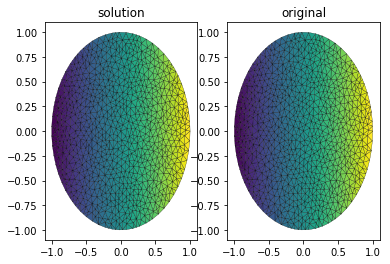

In [142]:
heat(x * t, 100, 'test2')

 t =  0.02 ,max error =  0.119143850559 L2 error =  0.028080746214877265
 t =  0.04 ,max error =  0.166014715507 L2 error =  0.047491287384350094
 t =  0.06 ,max error =  0.194529531809 L2 error =  0.06303531101590554
 t =  0.08 ,max error =  0.216105206045 L2 error =  0.0762039705134267
 t =  0.1 ,max error =  0.232531637677 L2 error =  0.087741535162707
 t =  0.12000000000000001 ,max error =  0.245632253306 L2 error =  0.09809751928621381
 t =  0.14 ,max error =  0.257163593544 L2 error =  0.10756976198010129
 t =  0.16 ,max error =  0.266993394441 L2 error =  0.11636493474584816
 t =  0.18 ,max error =  0.27549470271 L2 error =  0.12462967121182748
 t =  0.19999999999999998 ,max error =  0.282967753358 L2 error =  0.1324689945426074
 t =  0.21999999999999997 ,max error =  0.289627843144 L2 error =  0.13995829946953
 t =  0.23999999999999996 ,max error =  0.29563313104 L2 error =  0.1471515997039032
 t =  0.25999999999999995 ,max error =  0.301101869288 L2 error =  0.1540873857511998

 t =  2.0000000000000013 ,max error =  0.407051045111 L2 error =  0.274791922069651


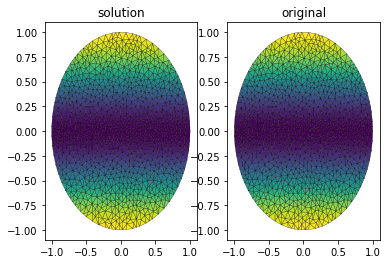

In [144]:
heat(x**2 * sym_trig.sin(y) + 18*sym_trig.cos(3*y) *sym_trig.sin(t**2), 100, 'test3')